# Задание для курсового проекта
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
Необходимо получить R2 > 0.6 на Private Leaderboard.
Укажите свой ник на kaggle
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

Файл должен содержать заголовки и комментарии
Повторяющиеся операции лучше оформлять в виде функций
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

# Connecting libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV, SGDRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime
from lightgbm import LGBMRegressor
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import lightgbm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
%matplotlib inline
plt.rcParams['figure.figsize']=12,10

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
#Уменьшение объема памяти, который занимает датасет**

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2   #смотрим текущее потребление памчти нашим датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:   # проходимся по всем нашим столбцам
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Paths to directories and files

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

### Dataset description


* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

# Загрузка датасета

In [7]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [9]:
print(f'количество строк в трейне:{df.shape[0]}')
print(f'количество строк в тесте:{test_df.shape[0]}') 

количество строк в трейне:10000
количество строк в тесте:5000


### Приведение типов

In [10]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
df.Id = df.Id.astype('str')
df['Id'].dtype

dtype('O')

# EDA

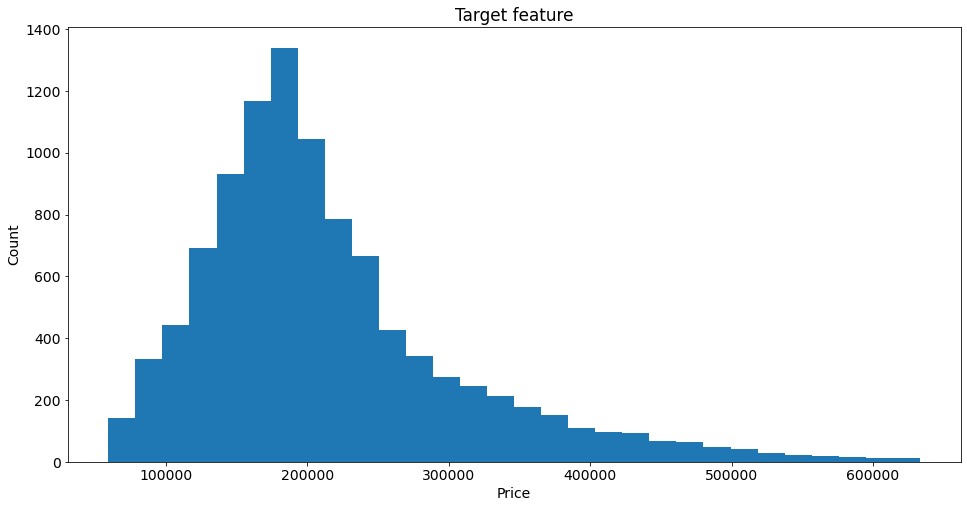

In [12]:
plt.figure(figsize=(16, 8))
plt.hist(df.Price, bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title("Target feature")
plt.show()

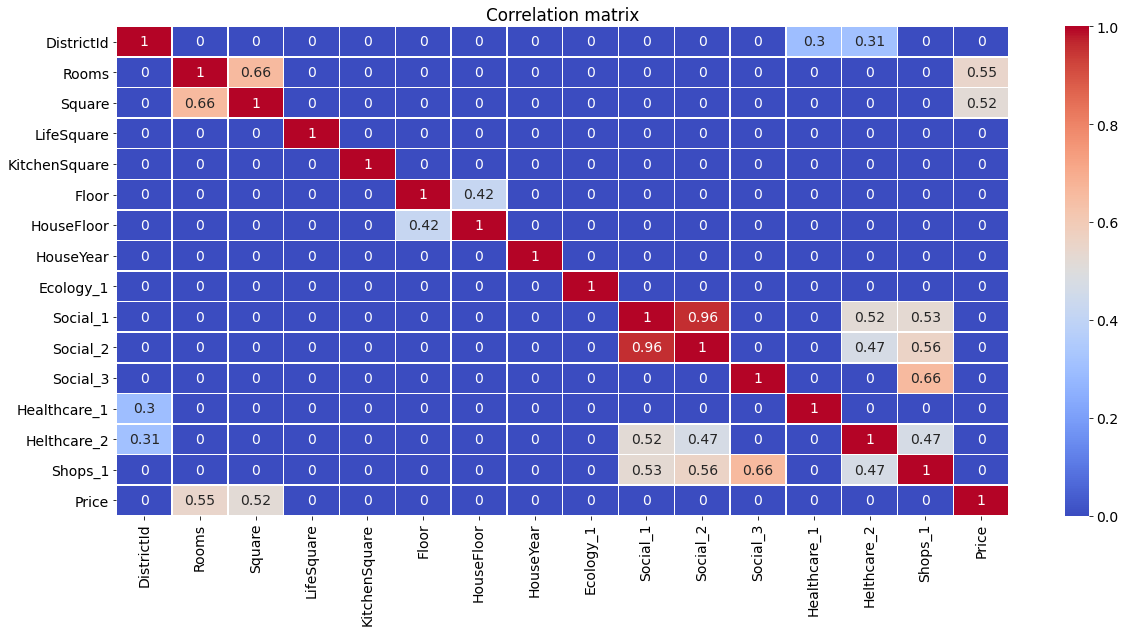

In [13]:
plt.figure(figsize=(20, 9))
corr_matrix = df.corr()  # присваиваем значение корреляции переменной
corr_matrix = np.round(corr_matrix, 2) # округляем корреляцию до 2 символов после запятой
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # зануляем корреляцию меньше 0,3

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')# annot=True - при значении False  не отображает цифры #в клеточках. cmap='coolwarm' - стиль цветов отображения корреляции

plt.title('Correlation matrix')
plt.show()



In [14]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

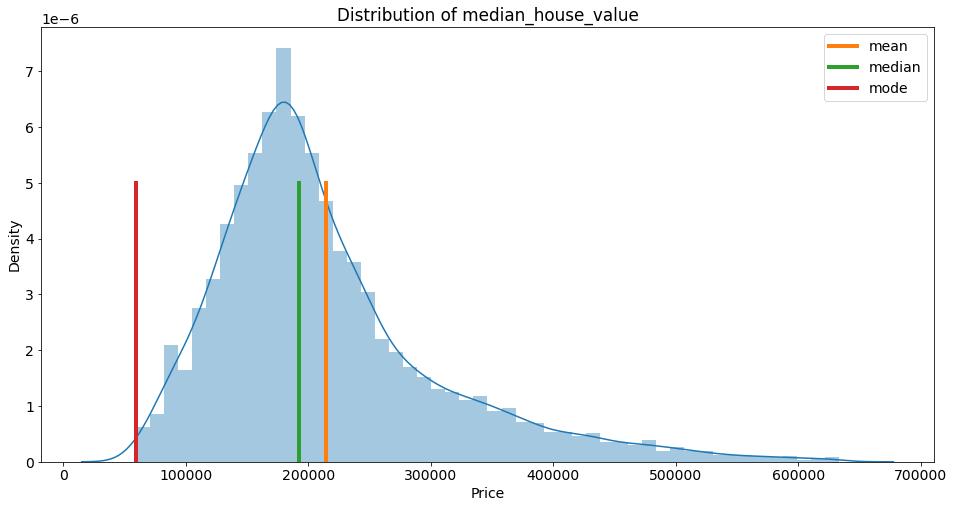

In [15]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [16]:
df.loc[df['DistrictId'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810
47,6186,1,1.0,62.006079,NaN,1.0,7,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,197006.124188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528
9978,4851,1,1.0,39.314342,NaN,1.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940
9983,647,1,2.0,63.324025,NaN,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698


In [17]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [18]:
df.select_dtypes(include='object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [19]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [20]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

### Detection and treatment of outliers

In [21]:
class DataPreprocessing:
    def __init__(self):
        self.medians = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None


        
    def fit(self, df):
        # Medians and quantiles
        self.medians = df.median() # medians
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.99) 
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.4) 
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03) 
        self.max_floor = df['Floor'].max()
        
        
        # Compute mean Helthcare_1 value in each district
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        # Life Square fillna
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.2), inplace=True)


        # Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Compute median room square and fill outliers with LifeSquare/Room_square 
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        # Square
        # If LifeSquare > Square: exchange values
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))


        # LifeSquare
        # Fill outliers with (Square - KithcenSquare)
        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, ['Square']] - df.loc[ls_condition, ['KitchenSquare']]
  
        
        # KitchenSquare
       
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = df.loc[condition_kitchen_square, 'Square'] - df.loc[condition_kitchen_square, 'LifeSquare'] \
        - (df.loc[condition_kitchen_square, 'Square'] * 0.1)
        
        df.loc[df['KitchenSquare'] < 0 , 'KitchenSquare' ] =df.loc[df['KitchenSquare'] < 0 , 'KitchenSquare' ] * -1


        # Ecology and Shops
        
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        
        # HouseFloor
        
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']

        
        # HouseYear

        current_year = datetime.now().year
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        
        
        # Healthcare
       
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        
        # Drop Id
        df.drop(['Id'], axis=1, inplace=True)

        
        # Fillna just in case
        df.fillna(self.medians, inplace=True)
        return df




In [22]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None

        
    def fit(self, df, y=None):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict() 
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict() 
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')
         
            
            
             #Target encoding
        ## District, Rooms
        df = df.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            

    
    def transform(self, df):
             
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Median square of flat in each district
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        
        
        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)
        
        return df
                # More categorical features
        df = self.floor_to_cat(df)  # + столбец floor_cat
        df = self.year_to_cat(df)   # + столбец year_cat
                # Target encoding
        if self.med_price_by_district is not None:
            df = df.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            df.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            df = df.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            df.fillna(self.med_price_by_floor_year_median, inplace=True)
    
        return df
    
    def floor_to_cat(self, df):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        df['floor_cat'] = pd.cut(df['Floor'], bins=bins, labels=False)

        df['floor_cat'].fillna(-1, inplace=True) 
        return df
     
    def year_to_cat(self, df):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        df['year_cat'] = pd.cut(df['HouseYear'], bins=bins, labels=False)

        df['year_cat'].fillna(-1, inplace=True)
        return df
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        
        
        
        return df


### Обработка данных

In [24]:
preprocessor = DataPreprocessing()
preprocessor.fit(df)
df = preprocessor.transform(df)
test_df = preprocessor.transform(test_df)

In [25]:
features_gen = FeatureGenerator()
features_gen.fit(df)
df = features_gen.transform(df)
df = features_gen.drop_outliers(df)
test_df = features_gen.transform(test_df)

In [26]:
y = pd.DataFrame(data=df['Price'])
df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.15, random_state=100)


In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()

In [29]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=df.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=df.columns)
y_test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

In [30]:
from sklearn.manifold import TSNE

In [31]:
tsne = TSNE(n_components=3, learning_rate=250, random_state=42)

In [32]:
X_train_tsne = tsne.fit_transform(X_train_scaled)

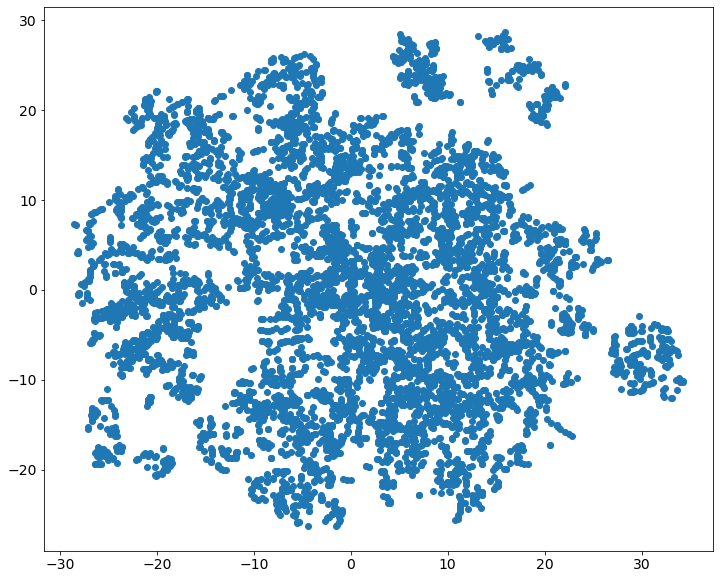

In [33]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])
plt.show()

In [34]:
from sklearn.cluster import KMeans

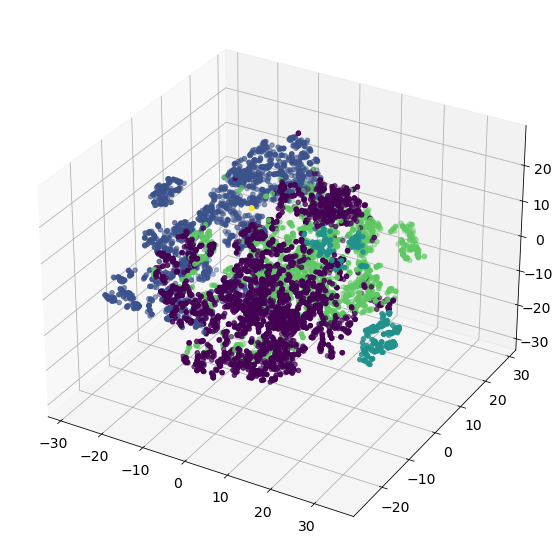

In [35]:
model = KMeans(n_clusters=5, random_state=42, max_iter=200)
model_kmeans = model.fit_predict(X_train_scaled)
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = X_train_tsne[:, 0]
y = X_train_tsne[:, 1]
z = X_train_tsne[:, 2]

ax.scatter(x, y, z, c=model_kmeans)

plt.show()

In [36]:
model_kmeans_test = model.predict(X_test_scaled)
model_kmeans_test_final = model.predict(y_test_scaled)
X_train['klaster'] = model_kmeans
X_test['klaster'] = model_kmeans_test
test_df['klaster'] = model_kmeans_test_final

### Gradient Boosting Regressor 

In [37]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2400, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.014)

gb_model.fit(X_train, y_train)

#y_train_preds = gb_model.predict(X_train)
#y_test_preds = gb_model.predict(X_test)
#print(r2(y_train, y_train_preds))
#print(r2(y_test, y_test_preds))
#feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

#feature_importances.sort_values(by='importance', ascending=False)

0.856346521396071
0.8017194393810775


,feature_name,importance
2,Square,0.217410
17,DistrictPrice,0.171653
1,Rooms,0.127113
3,LifeSquare,0.079980
20,klaster,0.065261
9,Social_2,0.056271
8,Social_1,0.044366
4,KitchenSquare,0.039462
19,Social,0.034633
10,Social_3,0.026472


In [39]:
rf = RandomForestRegressor(
    random_state=42, 
    max_depth=20,  
    criterion='mse',
    min_samples_leaf=5,  
    n_jobs=-1,
    n_estimators=1200,
    max_features=17
)
#rf.fit(X_train, y_train)
#y_train_preds_rf = rf.predict(X_train)
#y_test_preds_rf = rf.predict(X_test)
#print(r2(y_train, y_train_preds_rf))
#print(r2(y_test, y_test_preds_rf))

In [40]:
0.8834144127848591
0.7834426008529891

0.7834426008529891

In [41]:
rf2 = RandomForestRegressor(
    random_state=42, 
    max_depth=40, 
    criterion='mse',
    max_features=20, 
    n_jobs=-1,
    min_samples_leaf=5,
    n_estimators=1800  
)
#rf2.fit(X_train, y_train)
#y_train_preds_rf2 = rf2.predict(X_train)
#y_test_preds_rf2 = rf2.predict(X_test)
#print(r2(y_train, y_train_preds_rf2))
#print(r2(y_test, y_test_preds_rf2))

In [42]:
rf4 = RandomForestRegressor(
    random_state=42,
    criterion='mse',
    n_jobs=-1
)
#rf4.fit(X_train, y_train)
#y_train_preds_rf4 = rf4.predict(X_train)
#y_test_preds_rf4 = rf4.predict(X_test)
#print(r2(y_train, y_train_preds_rf4))
#print(r2(y_test, y_test_preds_rf4))

LGBMRegressor

In [43]:
%%time
import xgboost as xgb

xg = xgb.XGBRegressor(colsample_bytree=0.6, 
                              learning_rate=0.013, max_depth=6,
                              min_child_weight=0.2, 
                              n_estimators=1300,
                              reg_lambda=0.6,
                              random_state =42)
xg.fit(X_train, y_train)

#y_train_preds_xg = xg.predict(X_train)
#y_test_preds_xg = xg.predict(X_test)
#print(r2(y_train, y_train_preds_xg))
#print(r2(y_test, y_test_preds_xg))

Wall time: 6 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.013, max_delta_step=0, max_depth=6,
             min_child_weight=0.2, missing=nan, monotone_constraints='()',
             n_estimators=1300, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=0.6, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

DecisionTreeRegressor

In [44]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=7, 
                                 min_samples_leaf=3,
                                  max_features=20,
                                 random_state=42)
#dt_model.fit(X_train, y_train)
#y_train_preds_dt = dt_model.predict(X_train)
#y_test_preds_dt = dt_model.predict(X_test)
#print(r2(y_train, y_train_preds_dt))
#print(r2(y_test, y_test_preds_dt))

In [45]:
%%time
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor([
                           ('rf', rf),
                           ('rf2', rf2),
                            ('gb_model', gb_model),
                           ('rf4', rf4), 
                           ('xg', xg),
                            ('dt', dt_model)
                          ],
                          cv=4,
                          n_jobs=-1,
                          final_estimator= LinearRegression()) #RidgeCV ?
                             
stack.fit(X_train, y_train)
y_train_preds_s = stack.predict(X_train)
y_test_preds_s = stack.predict(X_test)
print(r2(y_train, y_train_preds_s))
print(r2(y_test, y_test_preds_s))

0.8968317411820883
0.800903941274707
Wall time: 4min 29s


In [47]:
test_df.shape

(5000, 21)

In [48]:
test_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Shops_1,Rooms_outlier,HouseFloor_outlier,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social,klaster
0,44,1.0,36.847630,19.094182,5.000000,9.0,1970.0,0.036122,24,4378,...,1036.0,1,0,0,1977.0,46.971646,4431.704675,1,-1.654285,0
1,62,1.0,42.568133,42.493907,10.000000,17.0,2017.0,0.072158,2,629,...,2300.0,0,0,0,1977.0,56.667328,2859.977368,1,-1.462656,1
2,27,2.0,59.463678,38.570943,9.000000,19.0,1977.0,0.211401,9,1892,...,900.0,1,0,0,1977.0,55.064041,2654.571480,3,-1.659865,1
3,23,3.0,49.646030,33.893825,6.000000,2.0,1965.0,0.014073,2,475,...,0.0,0,0,0,1977.0,54.345128,2093.831883,0,-1.662911,1
4,74,1.0,53.837056,42.069644,6.383706,17.0,1977.0,0.309479,35,7715,...,990.0,6,0,0,1977.0,56.148572,3483.810063,2,-0.847631,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,2.0,43.177521,30.339945,5.000000,6.0,1962.0,0.069660,31,6119,...,1783.4,2,0,1,1966.0,42.460503,4190.624398,1,-0.850724,0
4996,38,3.0,94.521465,93.698122,10.000000,27.0,2018.0,0.060753,15,2787,...,520.0,7,0,0,2011.0,65.410829,5033.548791,3,-1.257825,3
4997,101,1.0,33.656723,19.003259,5.000000,5.0,1966.0,0.038693,28,6533,...,1015.0,5,0,0,1967.0,46.416381,3970.074724,0,-1.450241,0
4998,10,1.0,38.635155,20.976257,9.000000,14.0,1970.0,0.089040,33,7976,...,900.0,11,0,0,1973.0,49.844005,4368.622761,2,-0.647366,0


In [49]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [50]:
predictions = stack.predict(test_df)
predictions

array([158729.75975934, 126096.99089473, 141546.37406321, ...,
       149975.70765095, 184790.16041765, 293409.03716779])

In [51]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,158729.759759
1,5925,126096.990895
2,960,141546.374063
3,3848,99796.819191
4,746,184272.954317


In [52]:
submit.to_csv('stack_lr_5.csv', index=False)